In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-nbcTwtEMFIYbUOvaHwPAWK4ru2s36kb)

<a id='section_5'></a>
## *4.* Ablation study

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from math import log10, sqrt
import time

import time

# Load the TensorBoard notebook extension
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

def get_mgrid(sidelen, dim=2):  #function to generate the coordinate grid
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''

    #torch.linspace(-1, 1, steps=sidelen):
    #Creates a one-dimensional tensor of size steps whose values are evenly
    #spaced from start (=-1) to end (=1), inclusive.

    #dim * [..]
    #replicate the content of [] dim times, the result will be a list of dim
    #elements (in this case tensors)

    #tuple([..])
    #transforms the list in input in a tuple

    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])

    #torch.meshgrid(*tensors):
    #Take N tensors, each of which can be either scalar or 1-dimensional vector,
    #and create N N-dimensional grids, where the i-th grid is defined by
    #expanding the i-th input over dimensions defined by other inputs.

    #torch.stack(...,dim=-1):
    #Concatenates a sequence of tensors along a new dimension
    #dim = -1 -> calculate the dimensions automatically

    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)

    #mgrid.reshape(-1, dim):
    #Returns a tensor with the same data and number of elements as input,
    #but with the specified shape.
    #dim = -1 -> calculate the dimensions automatically

    #from a list of lists (3 dimensions) to a single list (2 dimensions)

    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad(): #Context-manager that disables gradient calculation
            if self.is_first:
                #Fills the input Tensor with values drawn from the uniform distribution

                #Initialize weights
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)
            else:
                #Fills the input Tensor with values drawn from the uniform distribution

                #Initialize weights
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input): #forward pass
        return torch.sin(self.omega_0 * self.linear(input))
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []   #net

        #append the first sine layer
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        #append all the other sine layers
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        #if the outermost_linear bool is set then add a final linear layer
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad(): #Context-manager that disables gradient calculation
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        #nn.Sequential(*self.net):
        #A sequential container. Modules will be added to it in the order they
        #are passed in the constructor.

        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):  #forward pass
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords) #apply coords on net
        return output, coords        


In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        #torch.autograd.grad(...)
        #Computes and returns the sum of gradients of outputs w.r.t. the inputs.
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        #torch.ones_like(input)
        #Returns a tensor filled with the scalar value 1, with the same size as input.
        grad_outputs = torch.ones_like(y)

    #torch.autograd.grad(...)
    #Computes and returns the sum of gradients of outputs w.r.t. the inputs.
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [4]:
def get_cameraman_tensor(sidelength):
    #skimage.data.camera():
    #Gray-level “camera” image

    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5])) #normalize
    ])
    img = transform(img)  #image tensor of dimension (1, sidelength, sidelength)
    return img

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()

        #get the cameraman tensor with dimension sidelength
        #image tensor of dimension (1, sidelength, sidelength)
        img = get_cameraman_tensor(sidelength)

        #tensor.permute(*dims):
        #Returns a view of the original tensor with its dimensions permuted

        #I obtain an image tensor of dimension (sidelength, sidelength, 1)

        #tensor.view(*shape)
        #Returns a new tensor with the same data as the self tensor but of a
        #different shape
        #dim = -1 -> calculate the dimensions automatically

        #to obtain an image tensor of dimension (sidelength x sidelength, 1)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        #I obtain an image tensor of dimension (sidelength x sidelength, 1)
        #this represents the y (output) value for each pixel

        #get mgrid of the same dimension of the image (sidelength)
        self.coords = get_mgrid(sidelength, 2)
        #I obtain a grid tensor of dimension (sidelength x sidelength, 2)
        #this represents the (x1, x2) (input) pair for each pixel

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [6]:
def train_study(net, dataloader, writer, sub_study, val_study = None, lr=1e-4, gamma=0.1, total_steps = 1500, steps_til_summary = 100, size = 256):
  
  #define optimizer
  optimizer = torch.optim.Adam(lr=lr, params=net.parameters(), weight_decay=0.0005)
  scheduler= torch.optim.lr_scheduler.StepLR(optimizer, 800, gamma=gamma)
  #model_input is the grid (of (x1,x2) pairs)
  #ground_truth is the image (y values)
  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  losses = []

  # training
  for step in range(total_steps):

      #model_output is the output of the single forward pass, it is an output image
      #tensor of dimension (sidelength x sidelength, 1);
      #this represents the y^ (output) value for each pixel

      #coords is a copy of the model_input pairs
      model_output, coords = net(model_input) #forward pass 

      #model_output and ground_truth (original image) have the same dimensions
      loss = ((model_output - ground_truth)**2).mean()  #calculate loss (MSE)

      if step % steps_til_summary == steps_til_summary-1:
          if val_study == None:
            writer.add_scalar(sub_study, loss, step)
            print("Step %d, Total loss %0.6f" % (step+1, loss))
          else:
            writer.add_scalar(sub_study, loss, val_study)
            print("Step %d, Total loss %0.6f, %s %0.2f" % (step+1, loss, sub_study, val_study))
          #img_grad = gradient(model_output, coords) #calculate output image gradient
          #img_laplacian = laplace(model_output, coords) #calculate output image laplacian

          fig, axes = plt.subplots(1,4, figsize=(18,6))
          axes[0].imshow(model_output.cpu().view(size,size).detach().numpy())
          #axes[1].imshow(img_grad.norm(dim=-1).cpu().view(size,size).detach().numpy())
          #axes[2].imshow(img_laplacian.cpu().view(size,size).detach().numpy())
          axes[3].imshow(ground_truth.cpu().view(size,size).detach().numpy())

          plt.show()

      optimizer.zero_grad() #Sets the gradients of all optimized torch.Tensor to zero
      loss.backward() ##apply gradients
      optimizer.step()  #make optimizer step
      scheduler.step()

  return loss.cpu()



In [ ]:
writer_folder = "Ablation_study_graph" + str(int(time.time()))
writer = SummaryWriter(writer_folder)

### Ablation study on omega 0 first

Step 500, Total loss 0.020726, first_omega_0 1.00


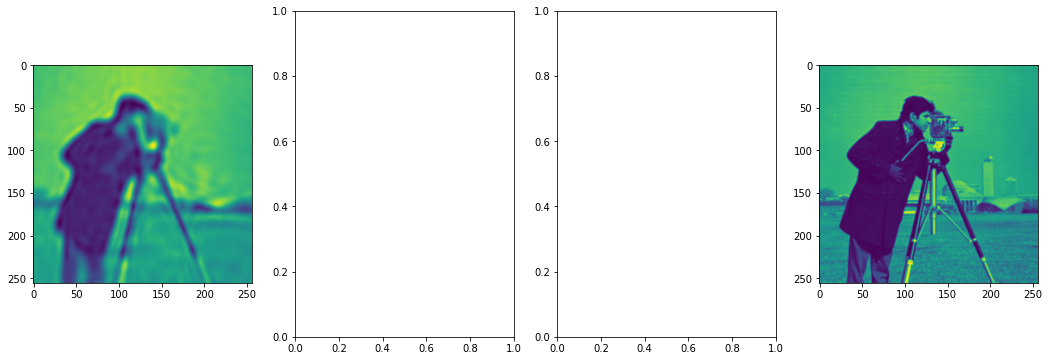

Step 500, Total loss 0.009973, first_omega_0 5.00


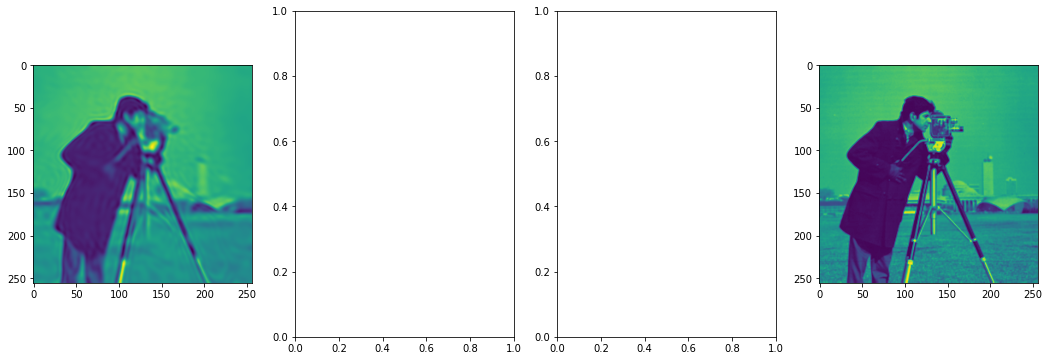

Step 500, Total loss 0.004599, first_omega_0 10.00


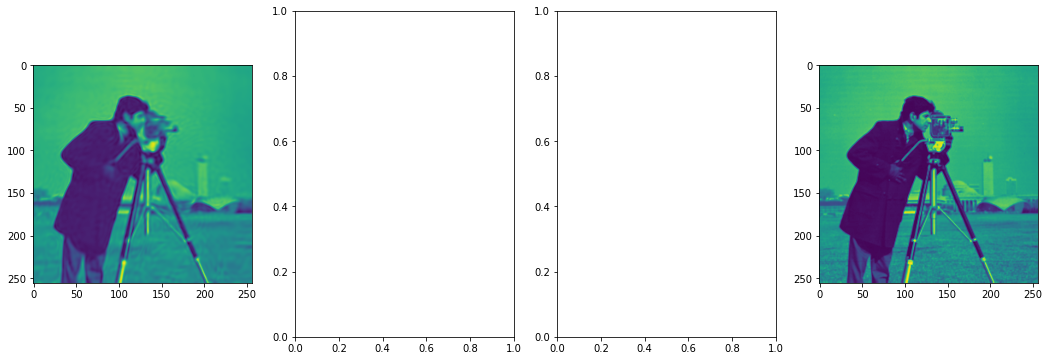

Step 500, Total loss 0.001450, first_omega_0 30.00


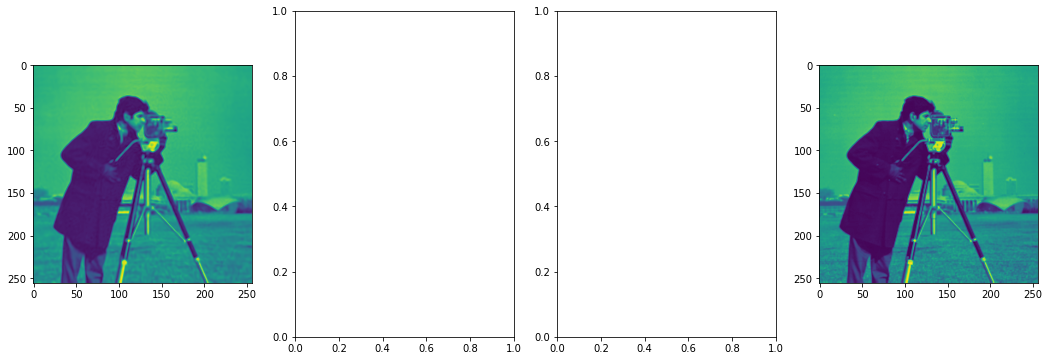

Step 500, Total loss 0.000784, first_omega_0 50.00


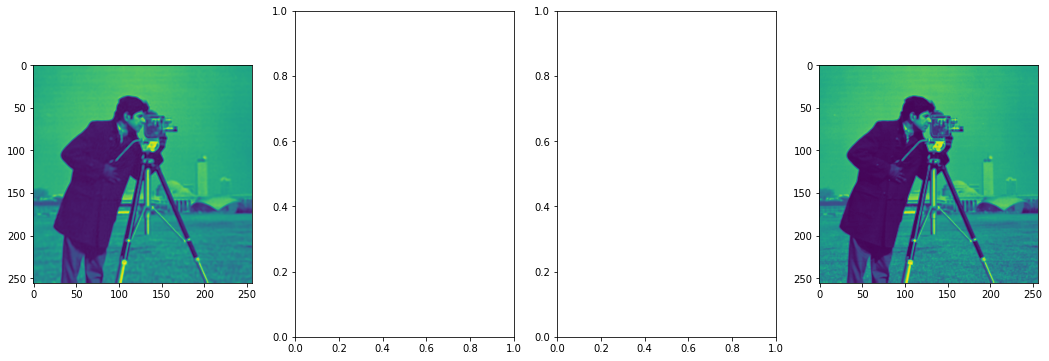

Step 500, Total loss 0.000404, first_omega_0 100.00


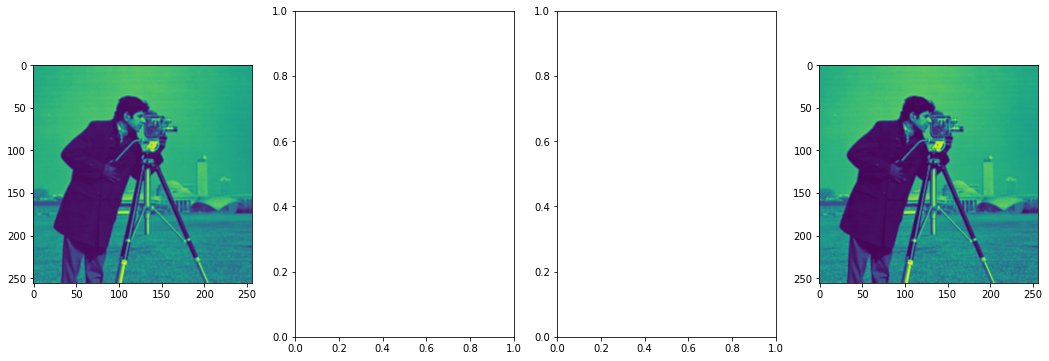

Step 500, Total loss 0.000043, first_omega_0 500.00


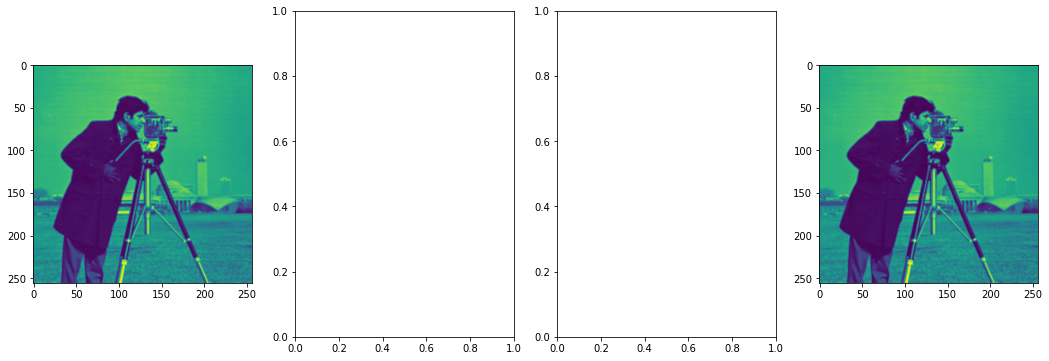

Step 500, Total loss 0.000046, first_omega_0 1000.00


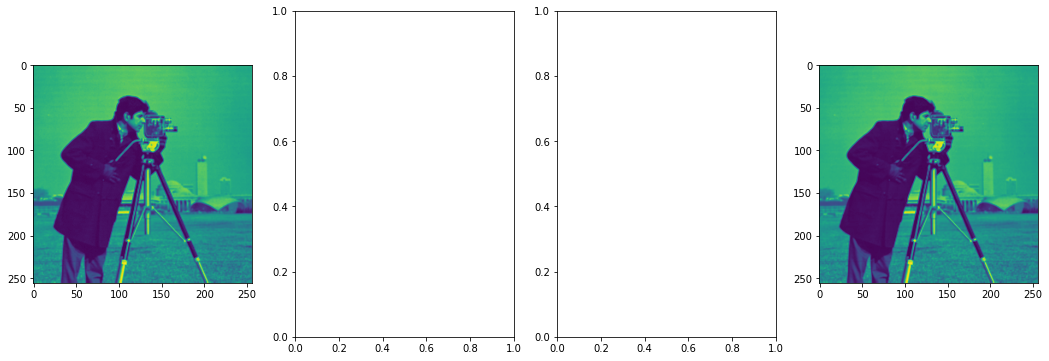

Step 500, Total loss 0.000417, first_omega_0 5000.00


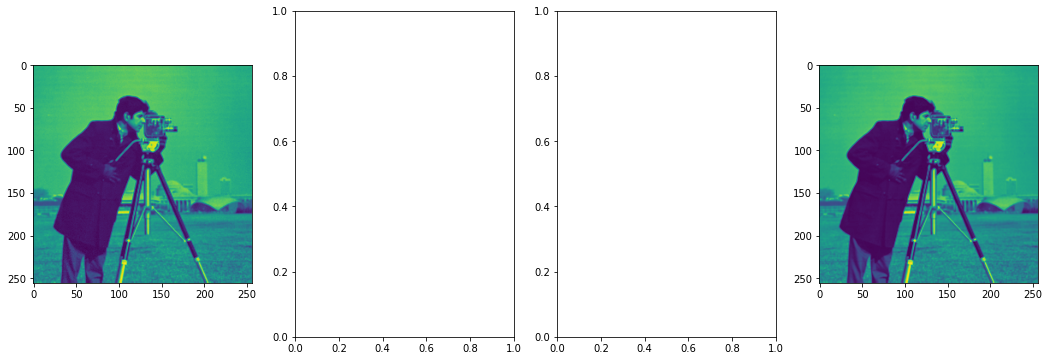

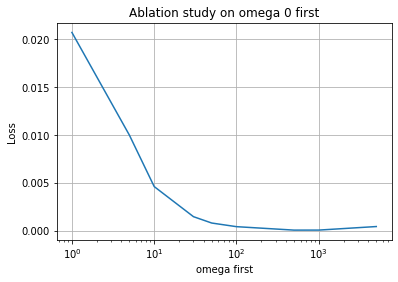

In [ ]:
#megas = [1, 5, 10, 30, 50, 100, 500, 1000, 5000, 10000, 50000]
omegas = [1, 5, 10, 30, 50, 100, 500, 1000, 5000]
losses = []
for omega in omegas:
  cameraman = ImageFitting(256)

  #instantiate data loader with a single batch (we have only one image)
  dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

  #instantiate siren net with number of input features = 2 ((x1,x2) pairs),
  #number of output features = 1 (y value), hidden features, hidden layers
  #and if to have the last layer as a linear layer or not
  img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                    hidden_layers=2, outermost_linear=True, first_omega_0=omega, hidden_omega_0=30.)

  img_siren.cuda()
  losses.append(train_study(img_siren, dataloader, writer, "first_omega_0", omega, lr=1e-4, gamma=0.1, total_steps = 500, steps_til_summary = 500, size = 256))

# plot results
plt.plot(omegas, losses)
plt.title('Ablation study on omega 0 first')
plt.ylabel('Loss')
plt.xlabel('omega first')
plt.xscale('log')
plt.grid()
plt.show()

### Ablation study on omega 0 hidden

Step 500, Total loss 0.022741, hidden_omega_0 1.00


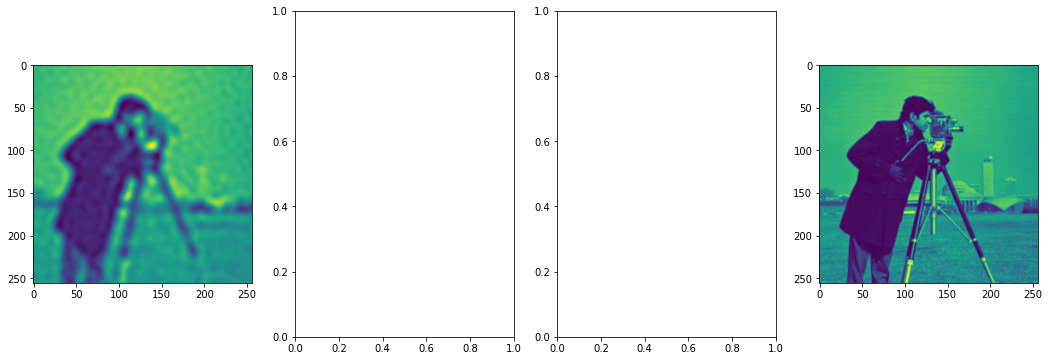

Step 500, Total loss 0.012678, hidden_omega_0 5.00


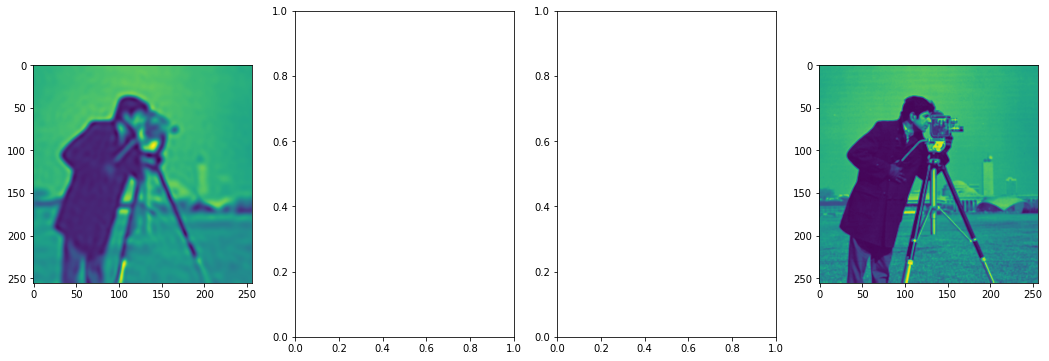

Step 500, Total loss 0.005884, hidden_omega_0 10.00


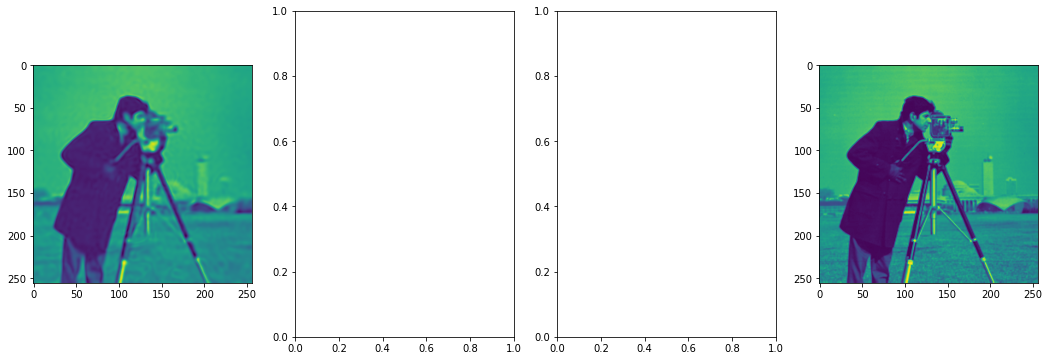

Step 500, Total loss 0.001520, hidden_omega_0 30.00


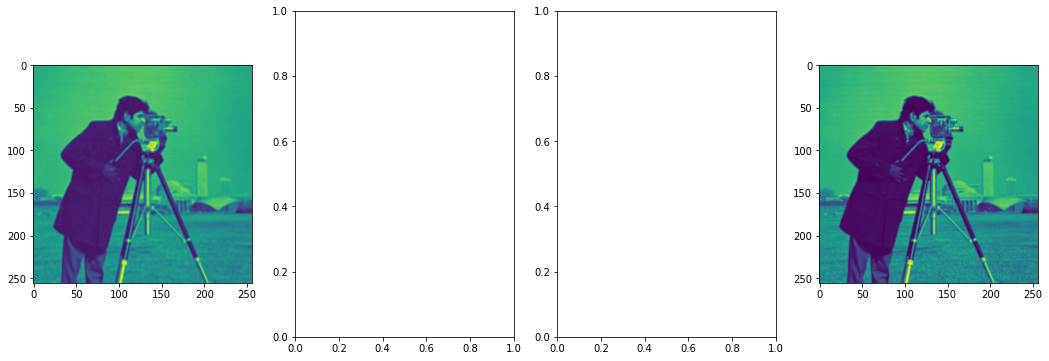

Step 500, Total loss 0.000806, hidden_omega_0 50.00


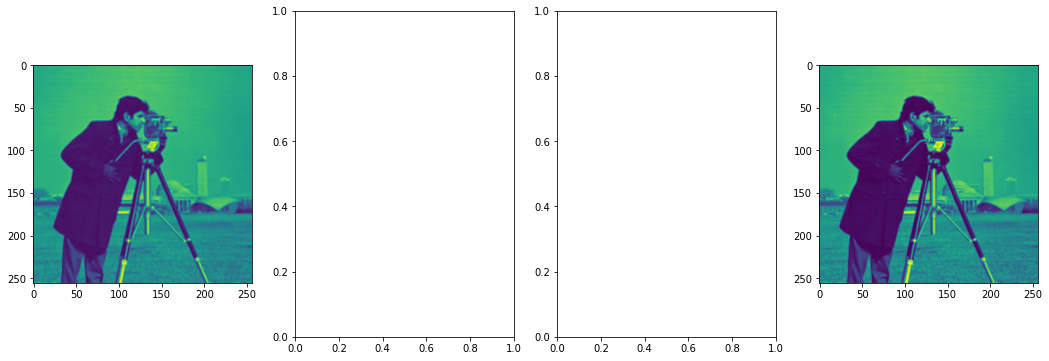

Step 500, Total loss 0.000738, hidden_omega_0 100.00


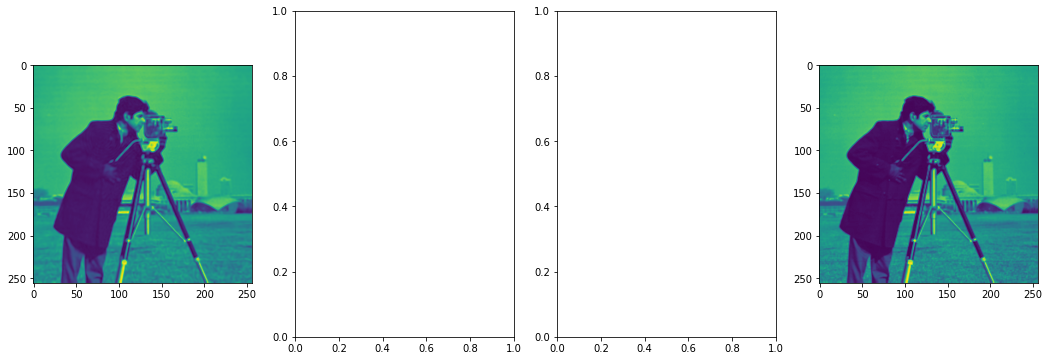

Step 500, Total loss 0.000270, hidden_omega_0 500.00


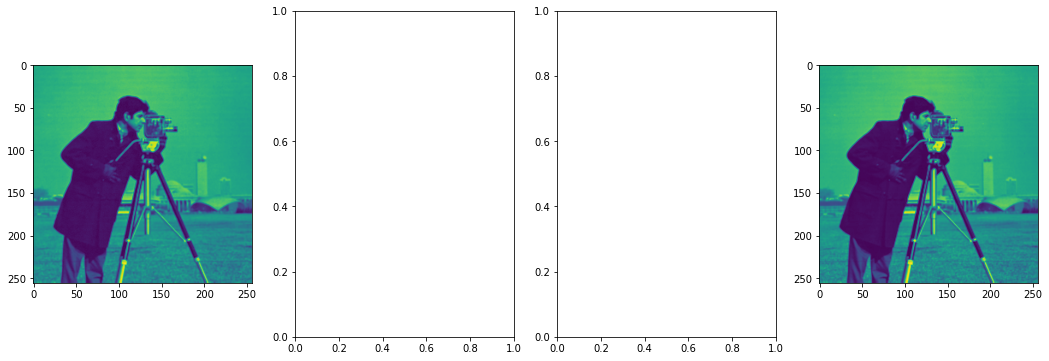

Step 500, Total loss 0.234600, hidden_omega_0 1000.00


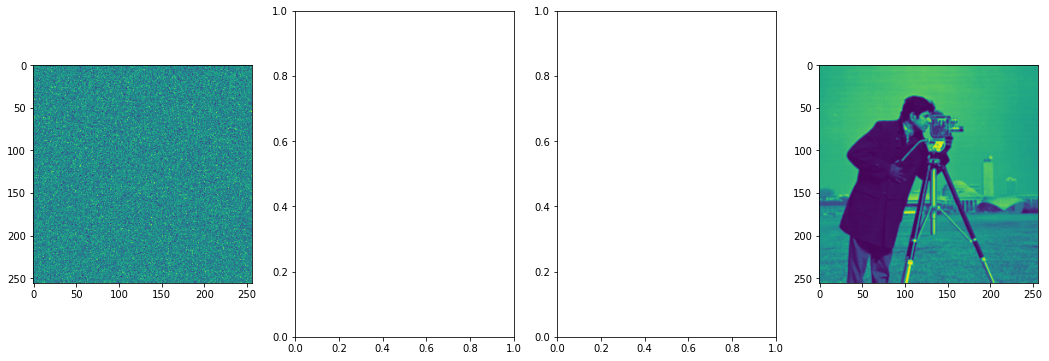

Step 500, Total loss 0.232512, hidden_omega_0 5000.00


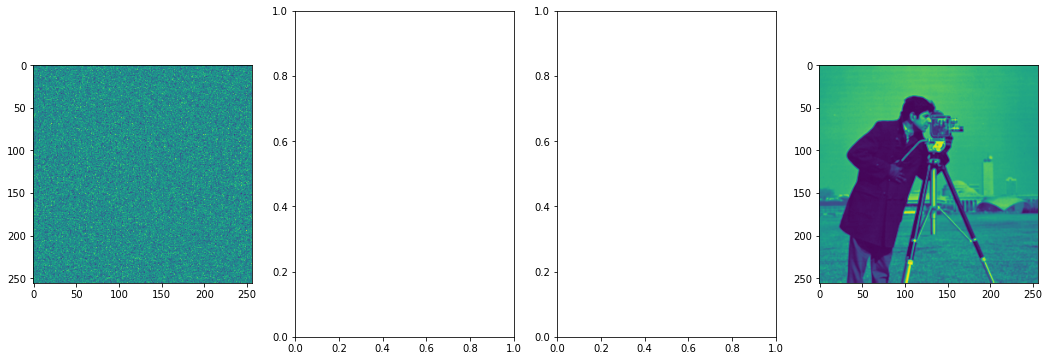

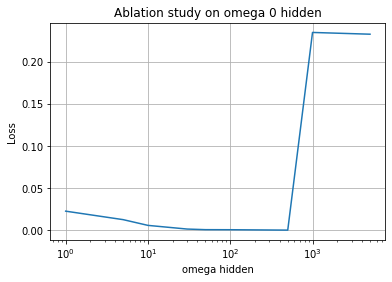

In [ ]:
omegas = [1, 5, 10, 30, 50, 100, 500, 1000, 5000]
losses = []
for omega in omegas:
  cameraman = ImageFitting(256)

  #instantiate data loader with a single batch (we have only one image)
  dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

  #instantiate siren net with number of input features = 2 ((x1,x2) pairs),
  #number of output features = 1 (y value), hidden features, hidden layers
  #and if to have the last layer as a linear layer or not
  img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                    hidden_layers=2, outermost_linear=True, first_omega_0=30, hidden_omega_0=omega)

  img_siren.cuda()
  losses.append(train_study(img_siren, dataloader, writer, "hidden_omega_0", omega, lr=1e-4, gamma=0.1, total_steps = 500, steps_til_summary = 500, size = 256))


# plot results
plt.plot(omegas, losses)
plt.title('Ablation study on omega 0 hidden')
plt.ylabel('Loss')
plt.xlabel('omega hidden')
plt.xscale('log')
plt.grid()
plt.show()  

### Ablation study on number of layers

Step 500, Total loss 0.006007, layers 1.00


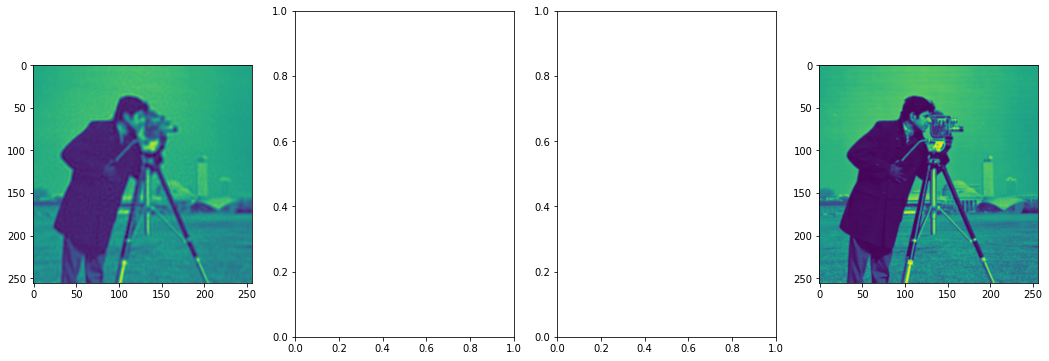

Step 500, Total loss 0.001401, layers 2.00


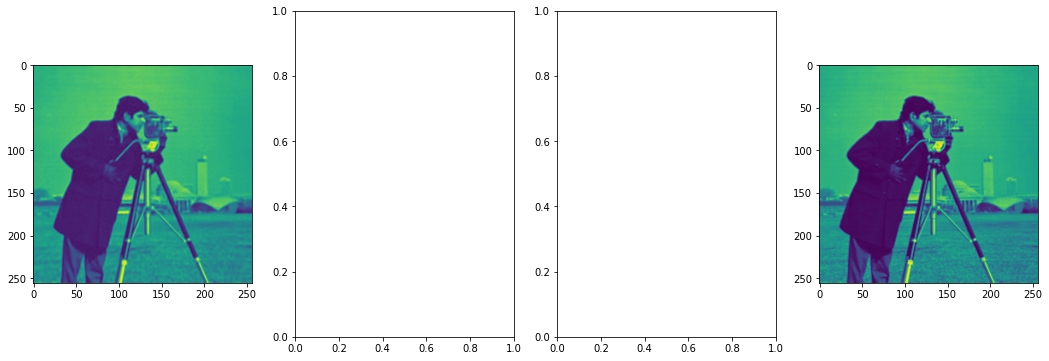

Step 500, Total loss 0.000498, layers 5.00


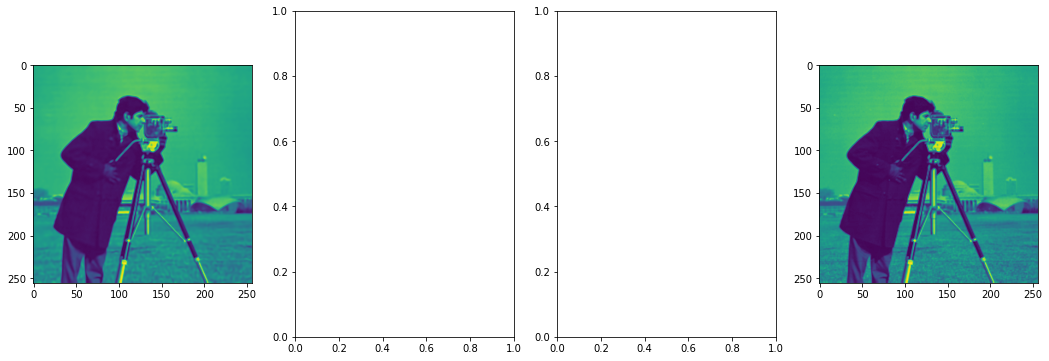

Step 500, Total loss 0.000327, layers 8.00


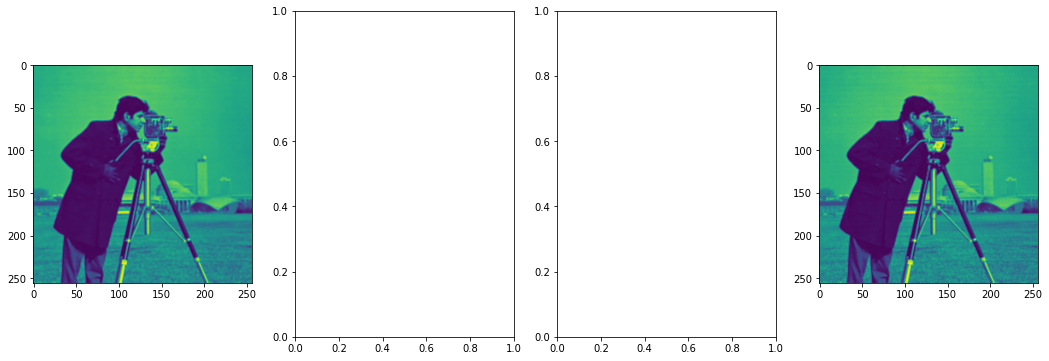

Step 500, Total loss 0.000291, layers 10.00


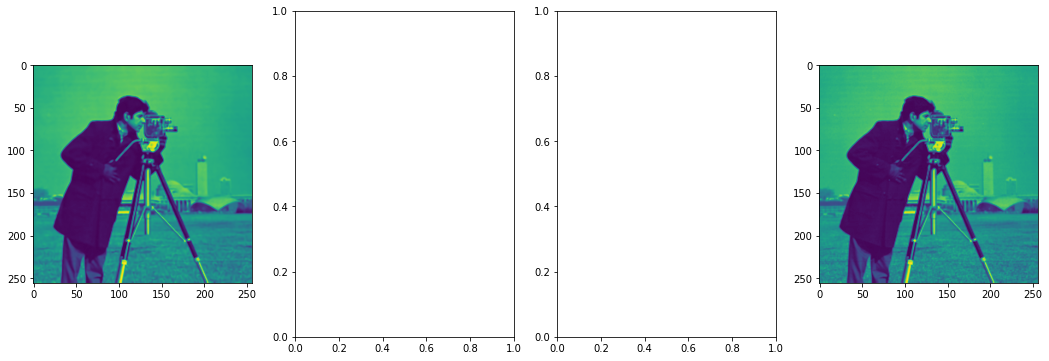

Step 500, Total loss 0.000151, layers 12.00


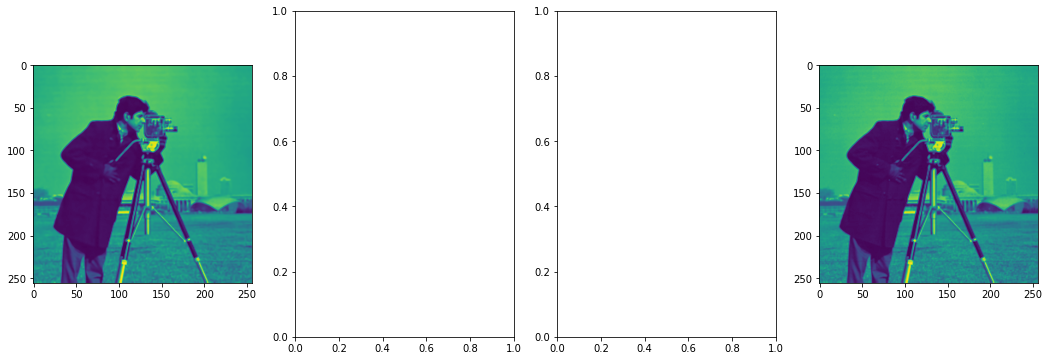

Step 500, Total loss 0.043358, layers 15.00


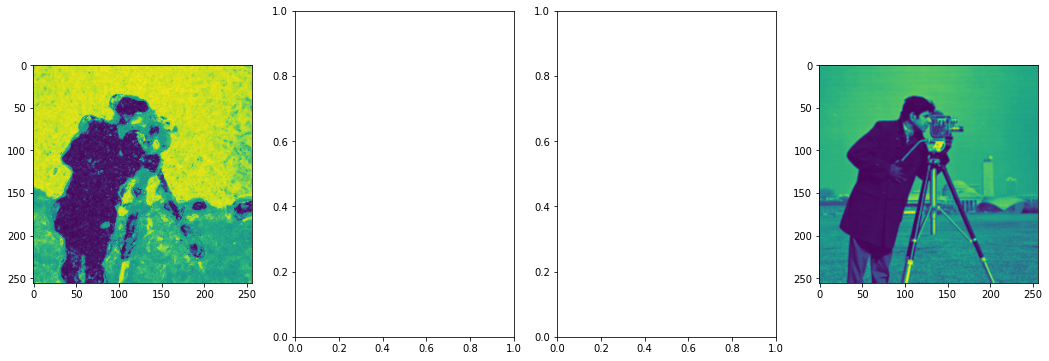

Step 500, Total loss 0.000135, layers 20.00


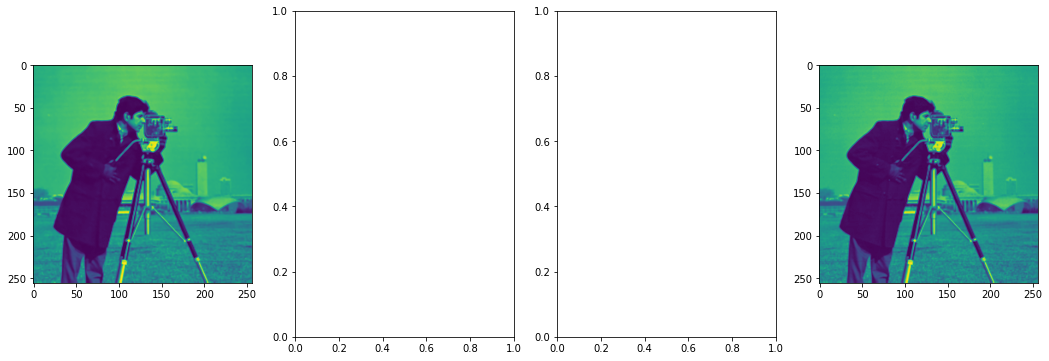

Step 500, Total loss 0.067974, layers 30.00


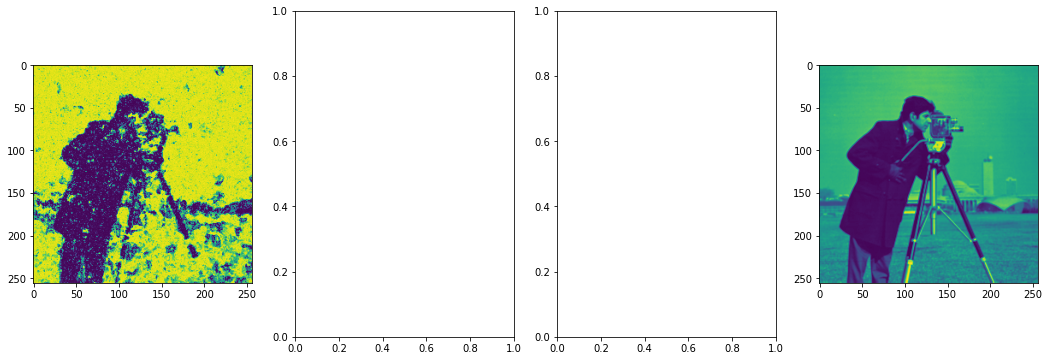

In [ ]:
layers = [1, 2, 5, 8, 10, 12, 15, 20, 30, 50]
#layers = [1, 2, 5, 8]
losses = []
for layer in layers:
  cameraman = ImageFitting(256)

  #instantiate data loader with a single batch (we have only one image)
  dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

  #instantiate siren net with number of input features = 2 ((x1,x2) pairs),
  #number of output features = 1 (y value), hidden features, hidden layers
  #and if to have the last layer as a linear layer or not
  img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                    hidden_layers=layer, outermost_linear=True, first_omega_0=30, hidden_omega_0=30.)

  img_siren.cuda()
  losses.append(train_study(img_siren, dataloader, writer, "layers", layer, lr=1e-4, gamma=0.1, total_steps = 500, steps_til_summary = 500, size = 256))    

# plot results
plt.plot(layers, losses)
plt.title('Ablation study on number of layers')
plt.ylabel('Loss')
plt.xlabel('# layers')
plt.grid()
plt.show() 

### Ablation study on number of features

In [ ]:
#features = [128, 256, 512, 1024]
features = [128, 256, 512, 1024]
losses = []
for feature in features:
  cameraman = ImageFitting(256)

  #instantiate data loader with a single batch (we have only one image)
  dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

  #instantiate siren net with number of input features = 2 ((x1,x2) pairs),
  #number of output features = 1 (y value), hidden features, hidden layers
  #and if to have the last layer as a linear layer or not
  img_siren = Siren(in_features=2, out_features=1, hidden_features=feature, 
                    hidden_layers=2, outermost_linear=True, first_omega_0=30, hidden_omega_0=30.)

  img_siren.cuda()
  losses.append(train_study(img_siren, dataloader, writer, "features", feature, lr=1e-4, gamma=0.1, total_steps = 500, steps_til_summary = 500, size = 256))

# plot results
plt.plot(features, losses)
plt.title('Ablation study on number of features')
plt.ylabel('Loss')
plt.xlabel('# featuress')
plt.grid()
plt.show() 

In [ ]:
writer.close()
%tensorboard --logdir {writer_folder}

### Ablation study on weight initialization/function on first layer

In [7]:
from collections import OrderedDict
import matplotlib
import numpy.fft as fft
import scipy.stats as stats


def eformat(f, prec, exp_digits):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%+0*d"%(mantissa, exp_digits+1, int(exp))

def format_x_ticks(x, pos):
    """Format odd tick positions
    """
    return eformat(x, 0, 1)

def format_y_ticks(x, pos):
    """Format odd tick positions
    """
    return eformat(x, 0, 1)

def get_spectrum(activations):
    n = activations.shape[0]

    spectrum = fft.fft(activations.numpy().astype(np.double).sum(axis=-1), axis=0)[:n//2]
    spectrum = np.abs(spectrum)

    max_freq = 100                
    freq = fft.fftfreq(n, 2./n)[:n//2]
    return freq[:max_freq], spectrum[:max_freq]


def plot_all_activations_and_grads(activations):
    num_cols = 4
    num_rows = len(activations)
    
    fig_width = 5.5
    fig_height = num_rows/num_cols*fig_width
    fig_height = 9
    
    fontsize = 5
        
    fig, axs = plt.subplots(num_rows, num_cols, gridspec_kw={'hspace': 0.3, 'wspace': 0.2},
                            figsize=(fig_width, fig_height), dpi=300)
    
    axs[0][0].set_title("Activation Distribution", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][1].set_title("Activation Spectrum", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][2].set_title("Gradient Distribution", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][3].set_title("Gradient Spectrum", fontsize=7, fontfamily='serif', pad=5.)

    x_formatter = matplotlib.ticker.FuncFormatter(format_x_ticks)
    y_formatter = matplotlib.ticker.FuncFormatter(format_y_ticks)

    spec_rows = []
    for idx, (key, value) in enumerate(activations.items()):    
        grad_value = value.grad.cpu().detach().squeeze(0)
        flat_grad = grad_value.view(-1)
        axs[idx][2].hist(flat_grad, bins=256, density=True)
        
        value = value.cpu().detach().squeeze(0) # (1, num_points, 256)
        n = value.shape[0]
        flat_value = value.view(-1)
            
        axs[idx][0].hist(flat_value, bins=256, density=True)
                
        if idx>1:
            if not (idx)%2:
                x = np.linspace(-1, 1., 500)
                axs[idx][0].plot(x, stats.arcsine.pdf(x, -1, 2), 
                                 linestyle=':', markersize=0.4, zorder=2)
            else:
                mu = 0
                variance = 1
                sigma = np.sqrt(variance)
                x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
                axs[idx][0].plot(x, stats.norm.pdf(x, mu, sigma), 
                                 linestyle=':', markersize=0.4, zorder=2)
        
        activ_freq, activ_spec = get_spectrum(value)
        axs[idx][1].plot(activ_freq, activ_spec)
        
        grad_freq, grad_spec = get_spectrum(grad_value)
        axs[idx][-1].plot(grad_freq, grad_spec)
        
        for ax in axs[idx]:
            ax.tick_params(axis='both', which='major', direction='in',
                                    labelsize=fontsize, pad=1., zorder=10) 
            ax.tick_params(axis='x', labelrotation=0, pad=1.5, zorder=10) 

            ax.xaxis.set_major_formatter(x_formatter)
            ax.yaxis.set_major_formatter(y_formatter)

In [8]:
writer_folder = "Ablation_study_graph_on_weight_first_layer" + str(int(time.time()))
writer = SummaryWriter(writer_folder)

In [11]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                #self.linear.weight.uniform_(-1 / self.in_features, 
                                             #1 / self.in_features) 
                self.linear.weight.zero_()

                #self.linear.weight.normal_(0, 1)    
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
                
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [12]:
cameraman = ImageFitting(256)

#instantiate data loader with a single batch (we have only one image)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

#instantiate siren net with number of input features = 2 ((x1,x2) pairs),
#number of output features = 1 (y value), hidden features, hidden layers
#and if to have the last layer as a linear layer or not
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=2, outermost_linear=True)


In [13]:
# save histogram of initial distribution
for m in img_siren.modules():
    if isinstance(m, SineLayer) and m.is_first:
        print(m.linear.weight.data.shape)
        print(m.linear.weight.data.view(-1).shape)
        writer.add_histogram('activation siren paper', m.linear.weight.data.view(-1))

torch.Size([256, 2])
torch.Size([512])


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


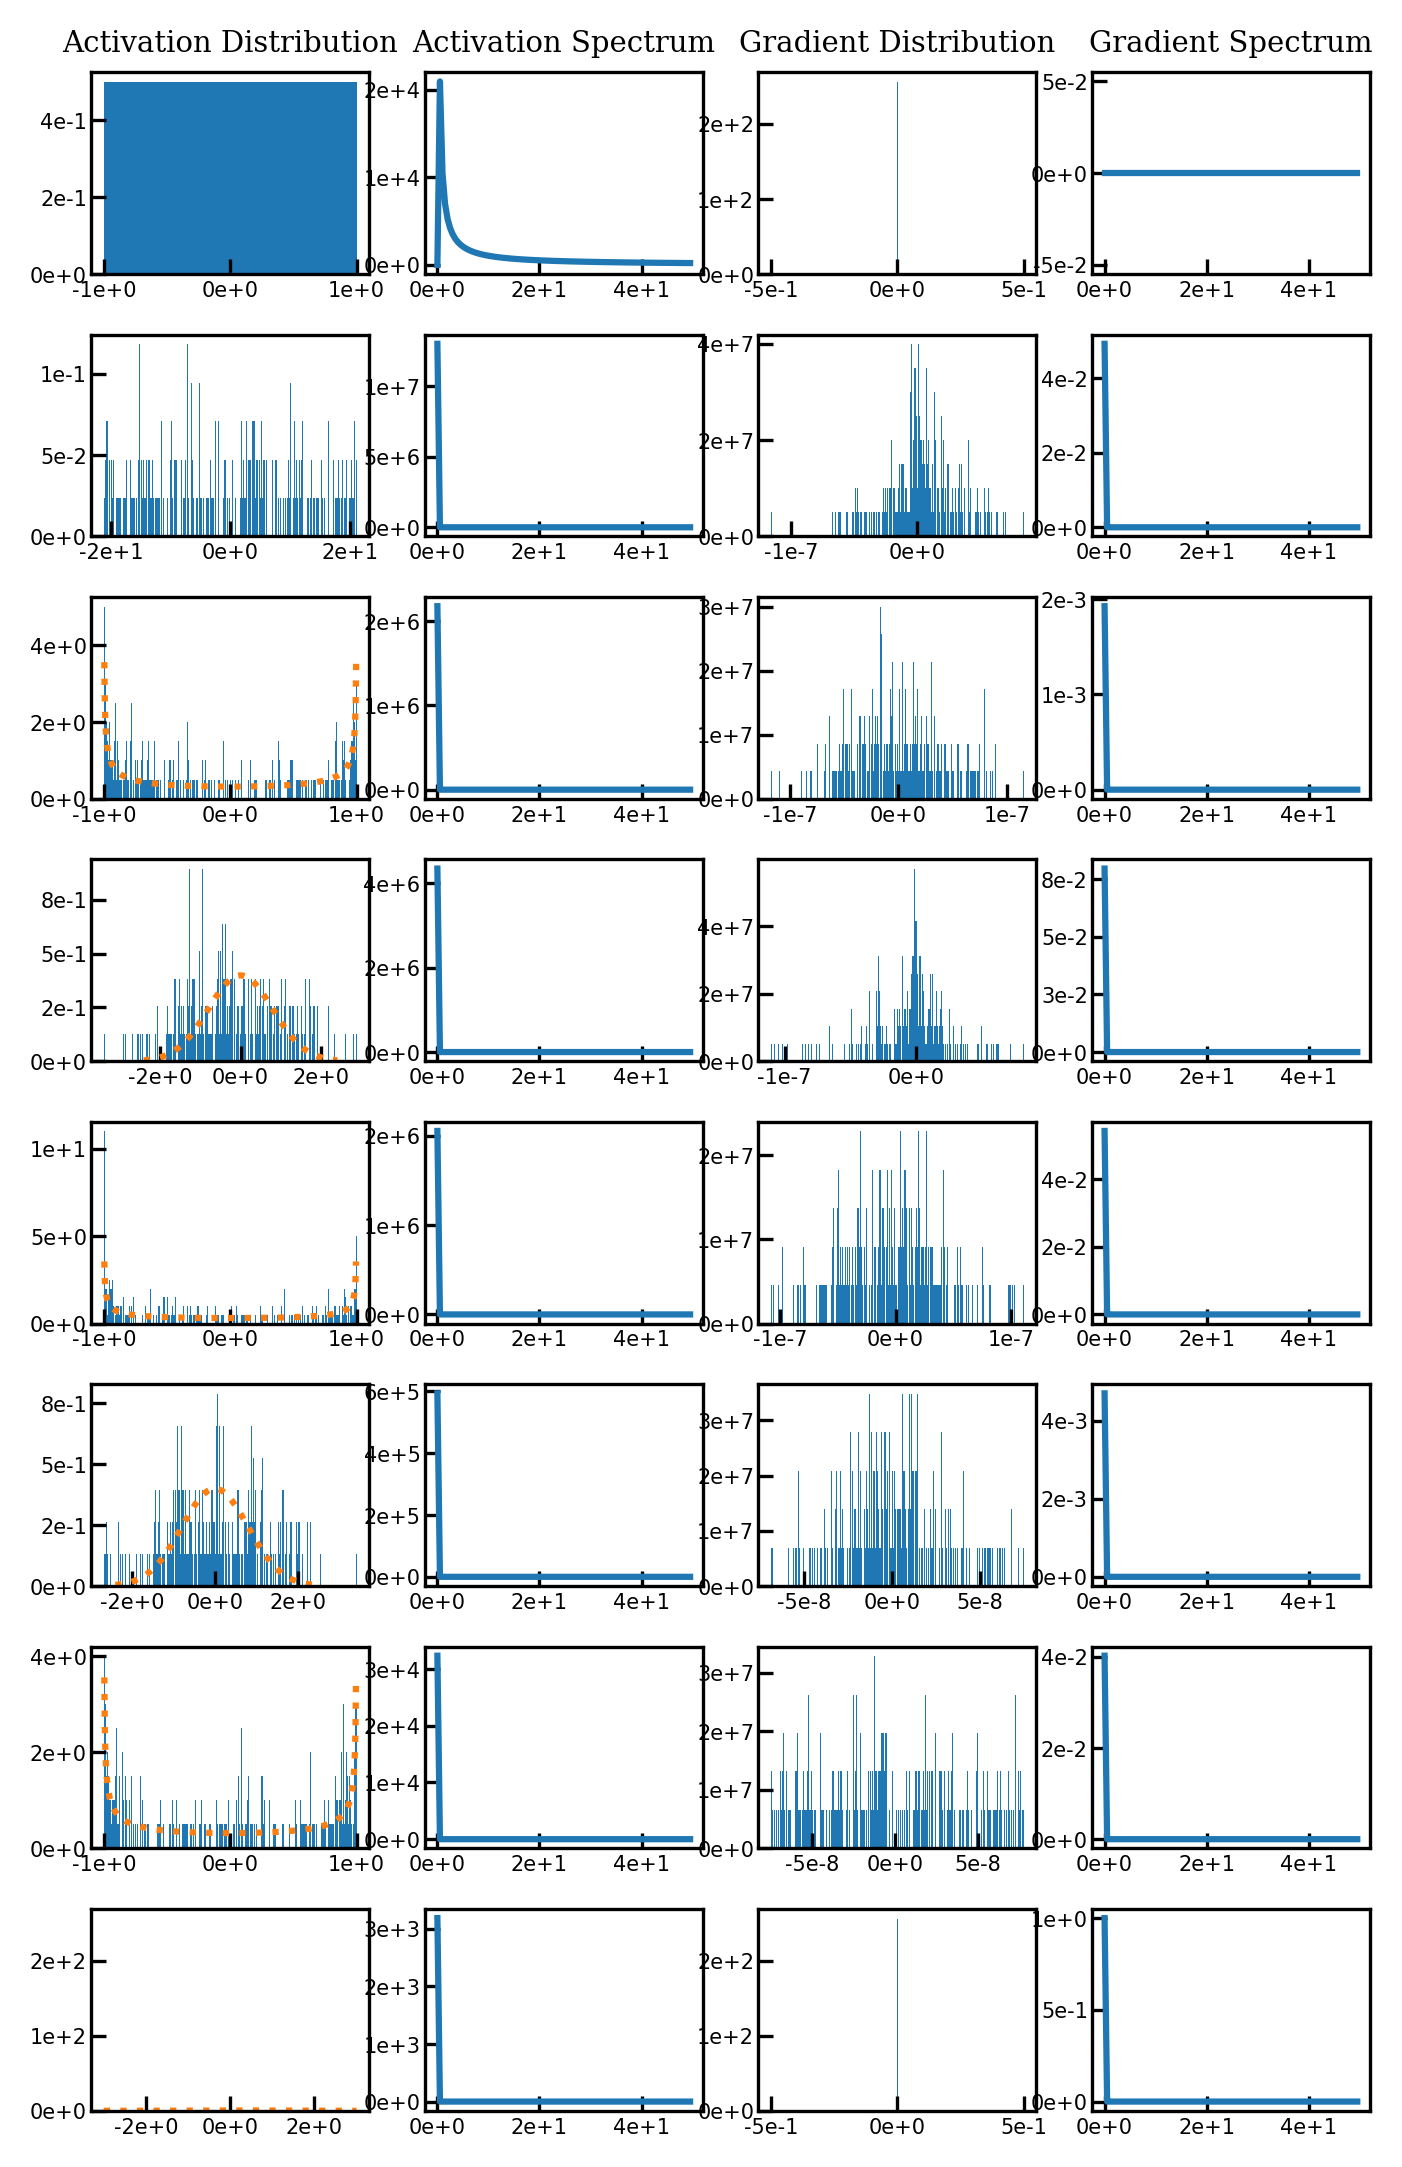

In [14]:
input_signal, _ = next(iter(dataloader))
activations = img_siren.forward_with_activations(input_signal, retain_grad=True)
output = activations[next(reversed(activations))]

# Compute gradients. Because we have retain_grad=True on 
# activations, each activation stores its own gradient!
output.mean().backward()

plot_all_activations_and_grads(activations)

Step 50, Total loss 0.178205


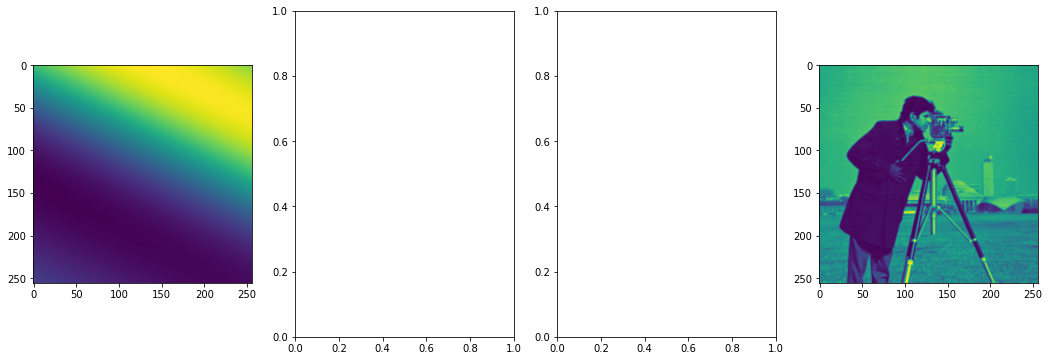

Step 100, Total loss 0.099431


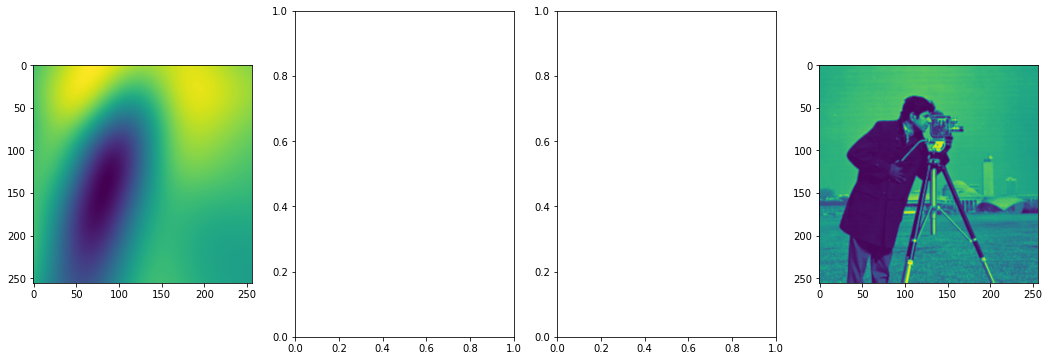

Step 150, Total loss 0.077070


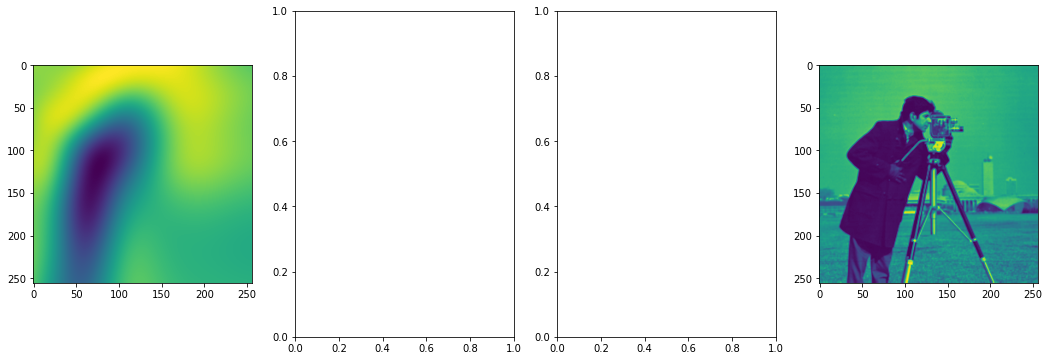

Step 200, Total loss 0.069952


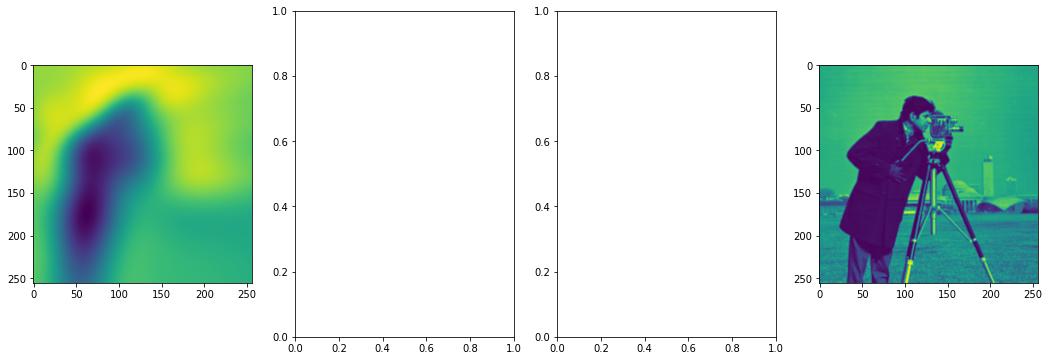

Step 250, Total loss 0.063447


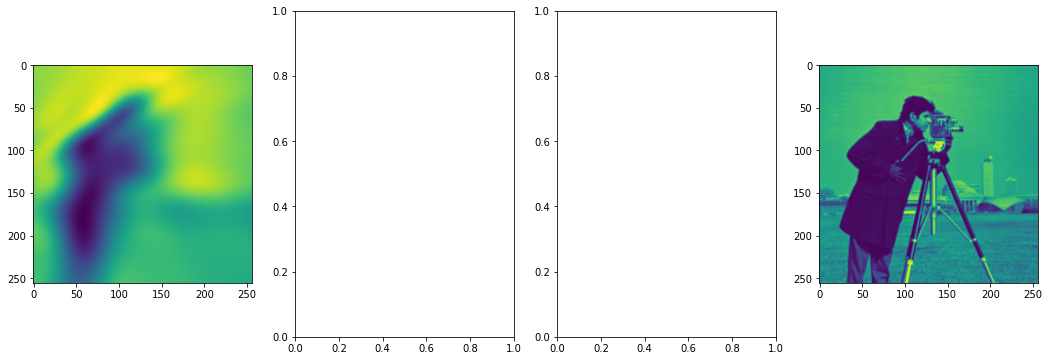

Step 300, Total loss 0.059364


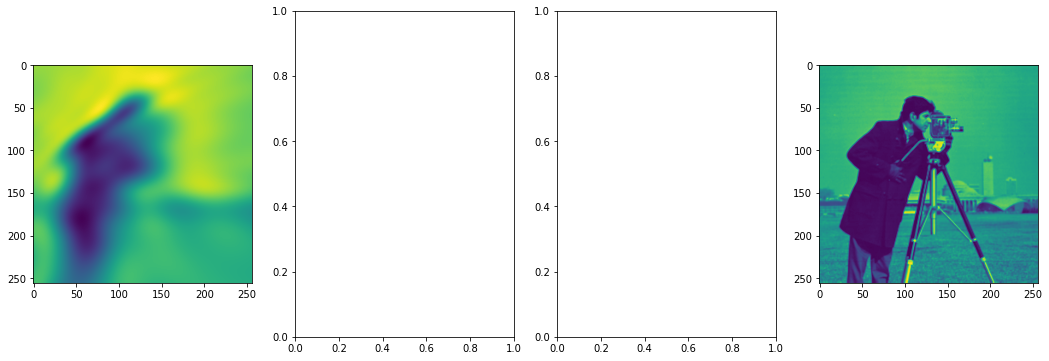

Step 350, Total loss 0.056411


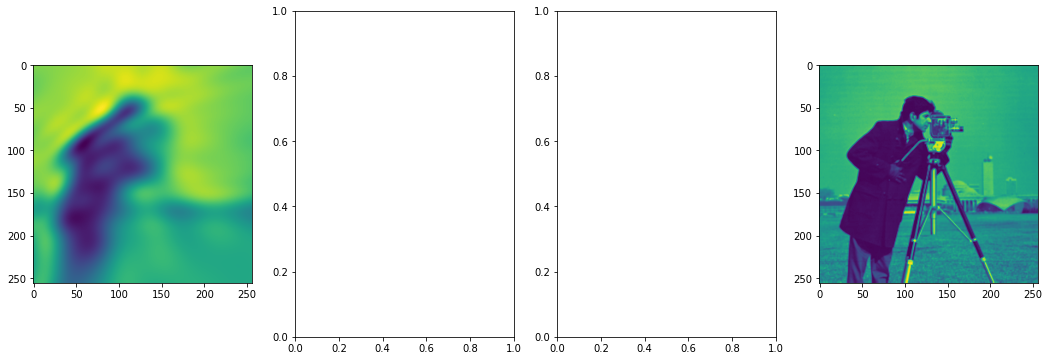

Step 400, Total loss 0.052375


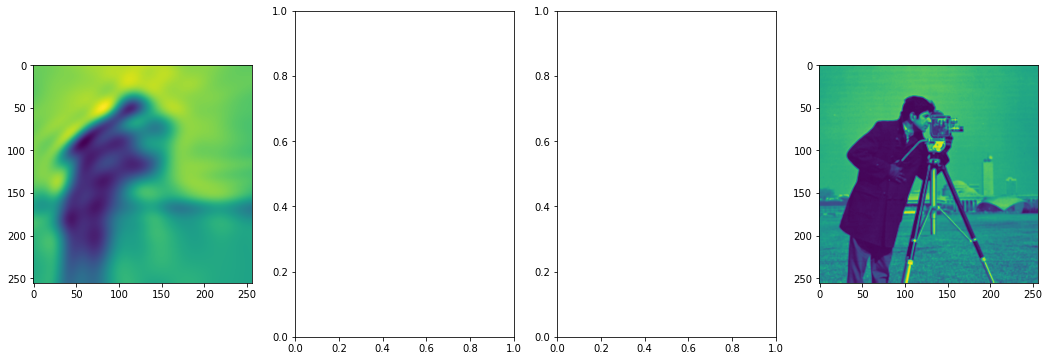

Step 450, Total loss 0.049104


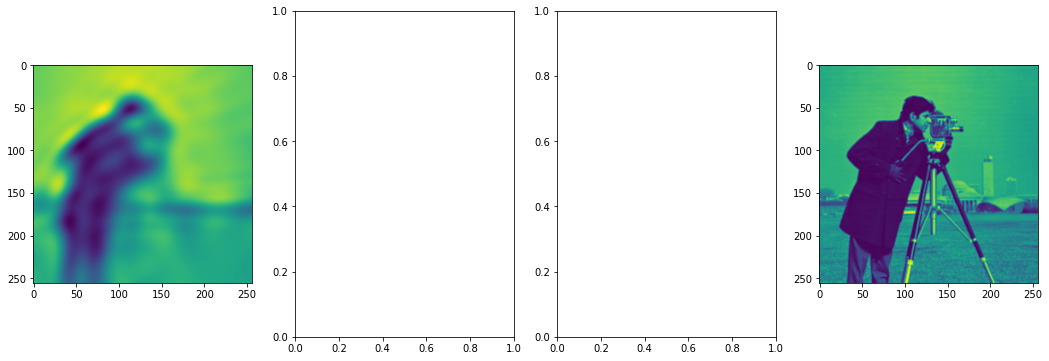

Step 500, Total loss 0.044759


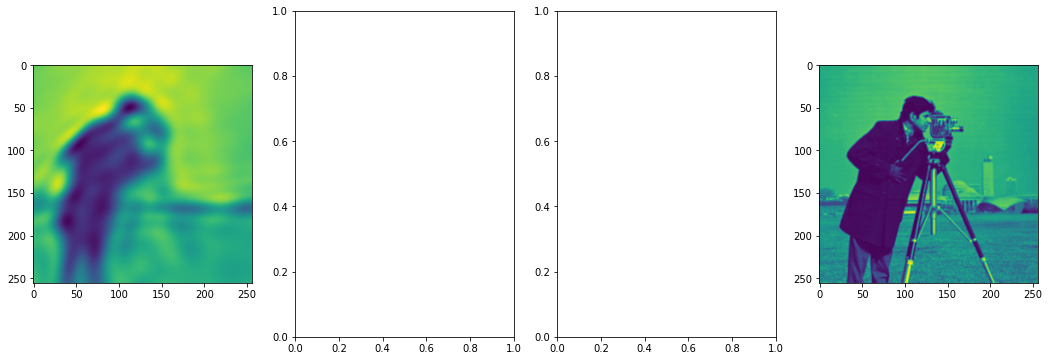

tensor(0.0448, grad_fn=<CopyBackwards>)

In [15]:
img_siren.cuda()
train_study(img_siren, dataloader, writer, "weight_inizialization_first_layer", lr=1e-4, gamma=0.1, total_steps = 500, steps_til_summary = 50, size = 256)

In [ ]:
writer.close()
%tensorboard --logdir {writer_folder}

### Ablation study on weight initialization/function on intermediate layers

In [ ]:
writer_folder = "Ablation_study_graph_on_weight_intermediate_layers" + str(int(time.time()))
writer = SummaryWriter(writer_folder)

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)     
            else:
                #self.linear.weight.uniform_(-np.sqrt(1 / self.in_features), 
                                            #np.sqrt(1 / self.in_features))
                '''self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)'''
                #self.linear.weight.zero_()

                self.linear.weight.normal_(0, 1)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [ ]:
cameraman = ImageFitting(256)

#instantiate data loader with a single batch (we have only one image)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

#instantiate siren net with number of input features = 2 ((x1,x2) pairs),
#number of output features = 1 (y value), hidden features, hidden layers
#and if to have the last layer as a linear layer or not
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=2, outermost_linear=True)


In [ ]:
# save histogram of initial distribution
num_layer = 1
for m in img_siren.modules():
    if isinstance(m, SineLayer) and not(m.is_first):
        print(m.linear.weight.data.shape)
        print(m.linear.weight.data.view(-1).shape)
        writer.add_histogram('activation siren paper'+str(num_layer), m.linear.weight.data.view(-1))
        num_layer = num_layer+1

torch.Size([256, 256])
torch.Size([65536])
torch.Size([256, 256])
torch.Size([65536])


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


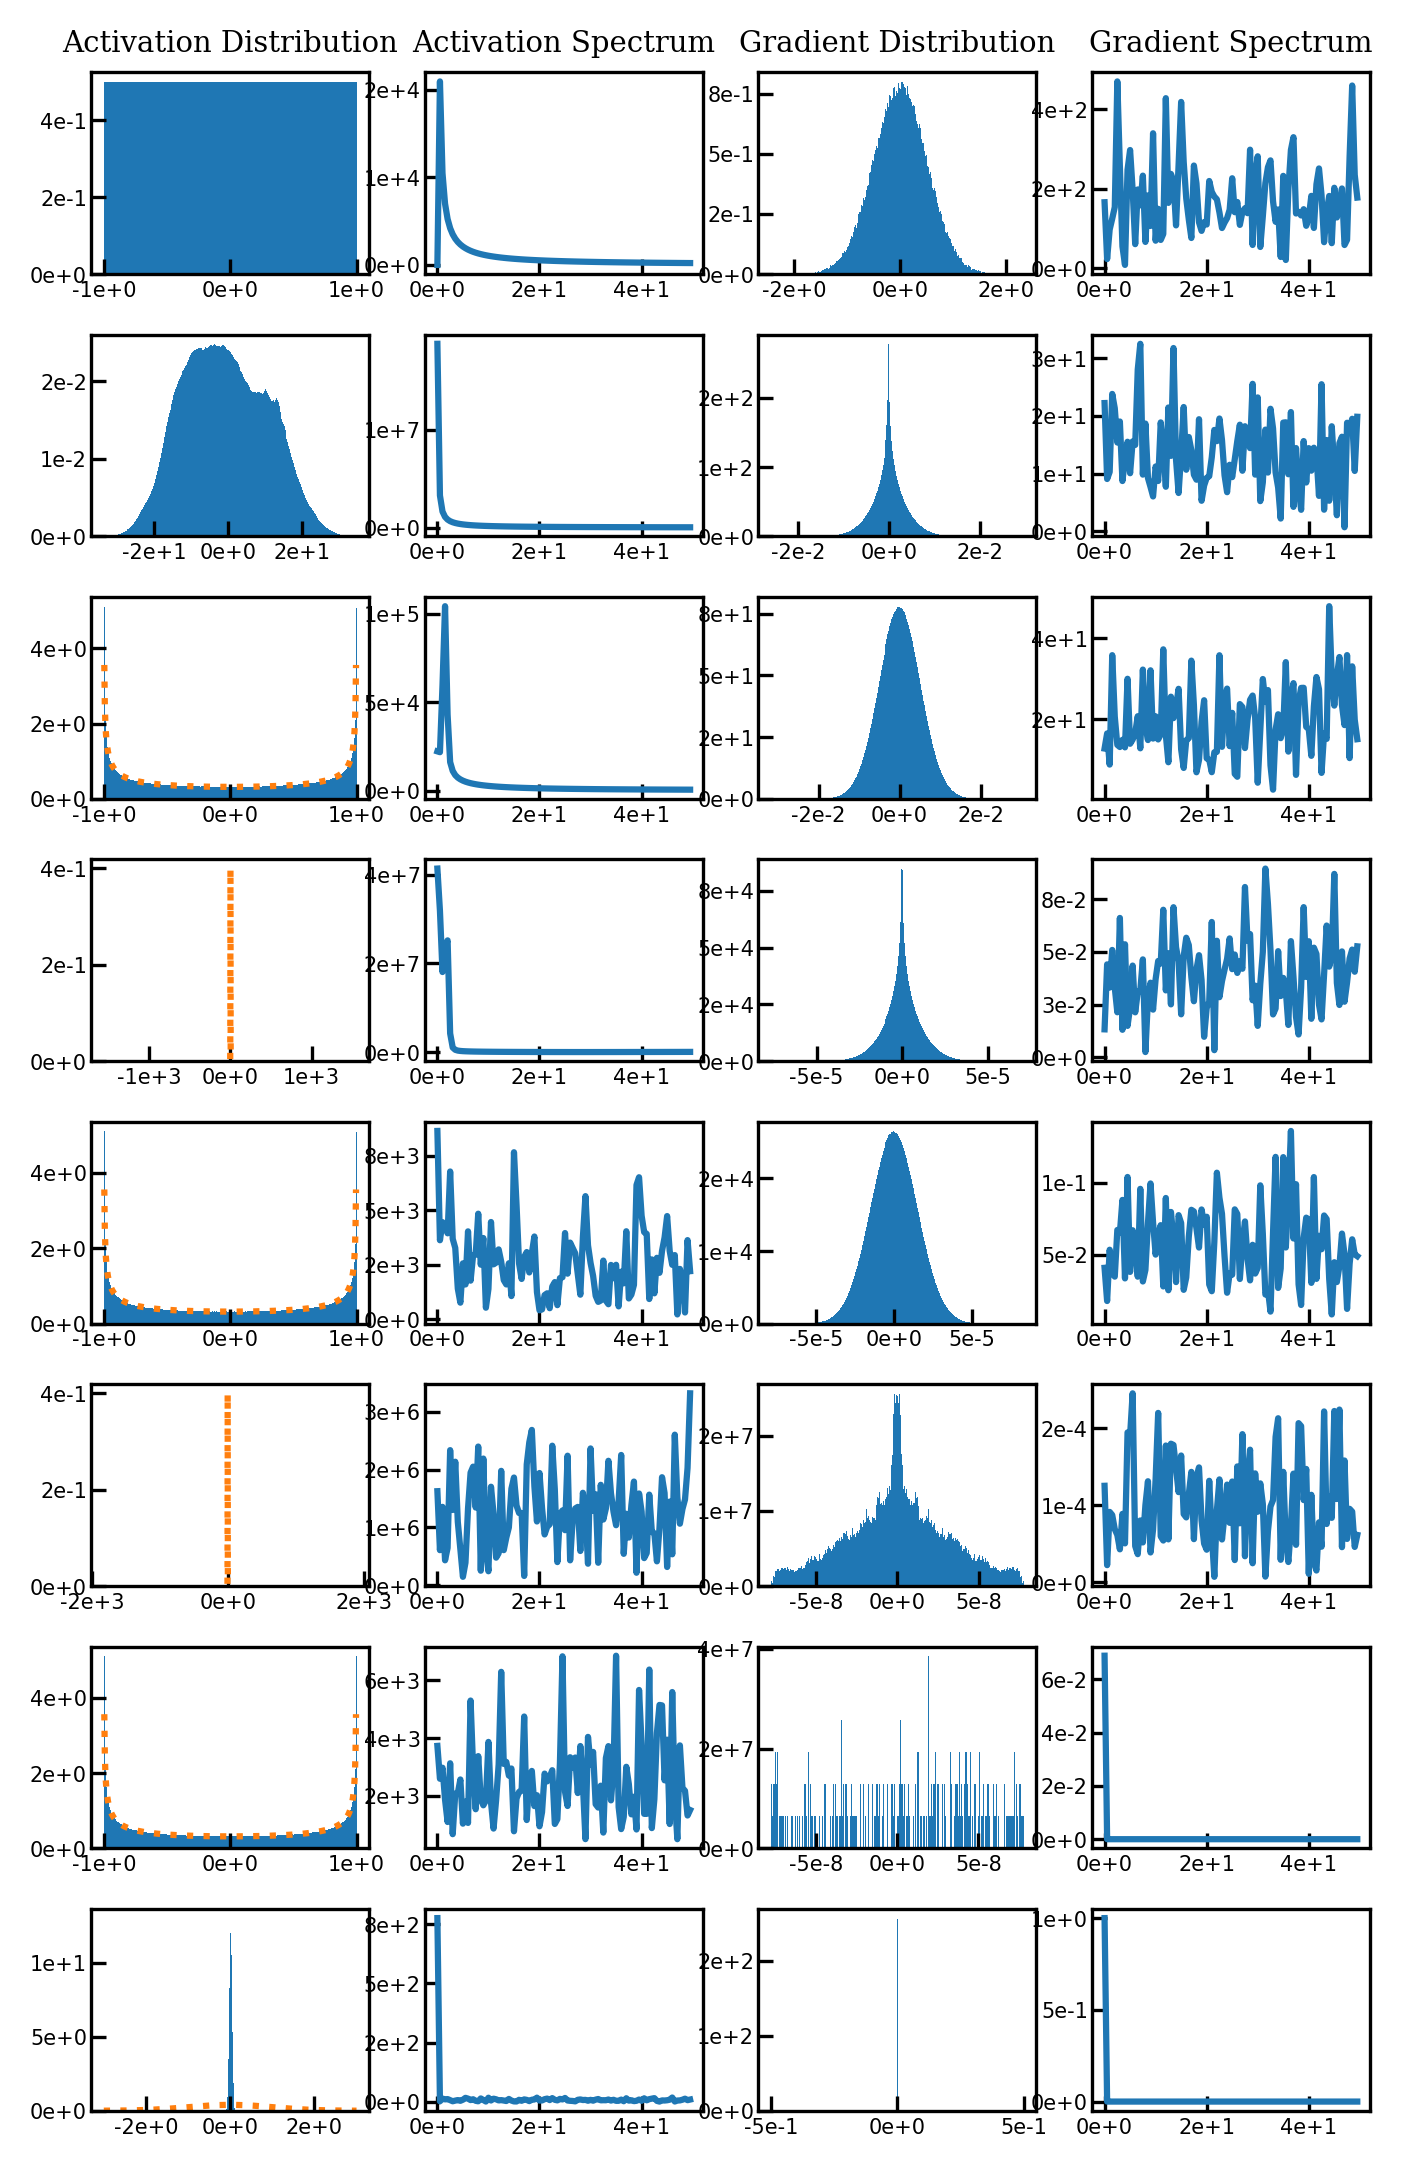

In [ ]:
input_signal, _ = next(iter(dataloader))
activations = img_siren.forward_with_activations(input_signal, retain_grad=True)
output = activations[next(reversed(activations))]

# Compute gradients. Because we have retain_grad=True on 
# activations, each activation stores its own gradient!
output.mean().backward()

plot_all_activations_and_grads(activations)

In [ ]:
img_siren.cuda()
train_study(img_siren, dataloader, writer, "weight_inizialization_hidden_layer", lr=1e-4, gamma=0.1, total_steps = 500, steps_til_summary = 50, size = 256)

In [ ]:
writer.close()
%tensorboard --logdir {writer_folder}